# Objective
* 20181226: 
    * Predict stock price in next day using linear regression
    * Given prices for the last N days, we train a model, and predict for day N+1

In [15]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import pandas_datareader as dr

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

%matplotlib inline

#### Input params ##################
stk_path = "./data/VTI.csv"
test_size = 0.2                 # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 30                       # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14
####################################

# Common functions

In [16]:
def get_preds_lin_reg(df, target_col, N, pred_min, offset):
    """
    Given a dataframe, get prediction at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe with the values you want to predict. Can be of any length.
        target_col : name of the column you want to predict e.g. 'adj_close'
        N          : get prediction at timestep t using values from t-1, t-2, ..., t-N
        pred_min   : all predictions should be >= pred_min
        offset     : for df we only do predictions for df[offset:]. e.g. offset can be size of training set
    Outputs
        pred_list  : the predictions for target_col. np.array of length len(df)-offset.
    """
    # Create linear regression object
    regr = LinearRegression(fit_intercept=True)

    pred_list = []

    for i in range(offset, len(df['adj_close'])):
        X_train = np.array(range(len(df['adj_close'][i-N:i]))) # e.g. [0 1 2 3 4]
        y_train = np.array(df['adj_close'][i-N:i]) # e.g. [2944 3088 3226 3335 3436]
        X_train = X_train.reshape(-1, 1)     # e.g X_train = 
                                             # [[0]
                                             #  [1]
                                             #  [2]
                                             #  [3]
                                             #  [4]]
        # X_train = np.c_[np.ones(N), X_train]              # add a column
        y_train = y_train.reshape(-1, 1)
    #     print X_train.shape
    #     print y_train.shape
    #     print 'X_train = \n' + str(X_train)
    #     print 'y_train = \n' + str(y_train)
        regr.fit(X_train, y_train)            # Train the model
        pred = regr.predict(np.array(N).reshape(1,-1))
    
        pred_list.append(pred[0][0])  # Predict the footfall using the model
    
    # If the values are < pred_min, set it to be pred_min
    pred_list = np.array(pred_list)
    pred_list[pred_list < pred_min] = pred_min
        
    return pred_list

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Load data

In [17]:
df = dr.get_data_yahoo('CBOM.ME')

# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df.index,format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,high,low,open,close,volume,adj_close,date,month
Date,,,,,,,,
2015-07-01,3.70647,3.59151,3.59448,3.64700,22199552.0,3.579847,2015-07-01,7
2015-07-02,3.76593,3.59151,3.76593,3.61281,27957072.0,3.546287,2015-07-02,7
2015-07-03,3.69160,3.59894,3.69160,3.60439,38557012.0,3.538022,2015-07-03,7
2015-07-06,3.63709,3.60736,3.60786,3.63709,8483465.0,3.570120,2015-07-06,7
2015-07-07,3.76593,3.59844,3.76593,3.59844,30759598.0,3.532182,2015-07-07,7
2015-07-08,3.62718,3.58804,3.58804,3.61628,40767635.0,3.549693,2015-07-08,7
2015-07-09,3.61727,3.59250,3.59250,3.61727,34994167.0,3.550665,2015-07-09,7
2015-07-10,3.76593,3.59943,3.76593,3.61727,27123497.0,3.550665,2015-07-10,7
2015-07-13,3.66484,3.60934,3.66484,3.62173,36299169.0,3.555043,2015-07-13,7


Text(0, 0.5, 'Руб.')

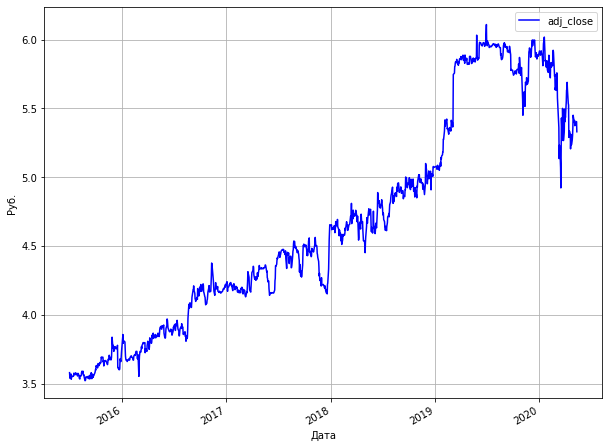

In [18]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("Дата")
ax.set_ylabel("Руб.")

# Split into train, dev and test set

In [19]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train].copy()
cv = df[num_train:num_train+num_cv].copy()
train_cv = df[:num_train+num_cv].copy()
test = df[num_train+num_cv:].copy()
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 736
num_cv = 244
num_test = 244
train.shape = (736, 8)
cv.shape = (244, 8)
train_cv.shape = (980, 8)
test.shape = (244, 8)


In [20]:
train_cv.nunique()

high         592
low          591
open         634
close        612
volume       975
adj_close    612
date         980
month         12
dtype: int64

In [21]:
test.count()

high         244
low          244
open         244
close        244
volume       244
adj_close    244
date         244
month        244
dtype: int64

# EDA

Text(0, 0.5, 'Руб.')

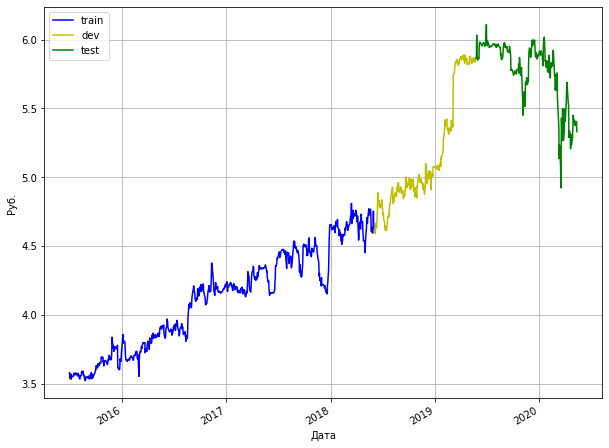

In [22]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("Дата")
ax.set_ylabel("Руб.")

# Predict using Linear Regression

In [23]:
RMSE = []
R2 = []
mape = []
for N in range(1, Nmax+1): # N is no. of samples to use to predict the next value
    est_list = get_preds_lin_reg(train_cv, 'adj_close', N, 0, num_train)
    
    cv.loc[:, 'est' + '_N' + str(N)] = est_list
    RMSE.append(math.sqrt(mean_squared_error(est_list, cv['adj_close'])))
    R2.append(r2_score(cv['adj_close'], est_list))
    mape.append(get_mape(cv['adj_close'], est_list))
print('RMSE = ' + str(RMSE))
print('R2 = ' + str(R2))
print('MAPE = ' + str(mape))
cv.head()

RMSE = [0.040828602344268716, 0.05963798684466986, 0.05073189663433612, 0.04885975850031042, 0.049697483037786816, 0.049949437812104695, 0.05098261452197103, 0.05206416333320262, 0.053860263172512274, 0.05564089542047935, 0.05728446149922131, 0.05899012818173752, 0.06059669875008496, 0.06274233443182224, 0.06484509674746369, 0.06735111186255466, 0.07004525131394132, 0.07270763189341183, 0.0750025609145646, 0.07709497399427688, 0.0789661311712786, 0.08061967962507545, 0.08209642928068862, 0.0832676910382959, 0.08425418869395015, 0.08492411831178424, 0.08521545059788316, 0.08528071123630213, 0.0850628012617181, 0.08475749214562077]
R2 = [0.9896371488943393, 0.9778896212863076, 0.9840002782676407, 0.9851593520203268, 0.9846460889615448, 0.9844900127527517, 0.983841745709386, 0.9831489091881523, 0.9819662031148024, 0.9807540899160377, 0.9796002943307889, 0.9783673904672253, 0.9771730356077714, 0.9755278808632477, 0.9738600641929246, 0.9718006062972121, 0.9694994530575357, 0.967136771143422

,high,low,open,close,volume,adj_close,date,month,est_N1,est_N2,...,est_N21,est_N22,est_N23,est_N24,est_N25,est_N26,est_N27,est_N28,est_N29,est_N30
Date,,,,,,,,,,,,,,,,,,,,,
2018-06-05,4.745,4.641,4.696,4.720,15685151.0,4.633090,2018-06-05,6,4.623274,4.592845,...,4.657419,4.673424,4.692614,4.700848,4.707082,4.711777,4.712459,4.709950,4.703213,4.697823
2018-06-06,4.742,4.659,4.733,4.676,12034507.0,4.589900,2018-06-06,6,4.633090,4.642906,...,4.635778,4.650963,4.666464,4.685146,4.693448,4.699859,4.704802,4.705875,4.703844,4.697685
2018-06-07,4.721,4.663,4.710,4.700,11345960.0,4.613458,2018-06-07,6,4.589900,4.546711,...,4.613622,4.623134,4.638021,4.653319,4.671765,4.680333,4.687097,4.692445,4.694048,4.692617
2018-06-08,4.760,4.656,4.688,4.753,9083730.0,4.665482,2018-06-08,6,4.613458,4.637016,...,4.603591,4.607505,4.616605,4.630942,4.645792,4.663773,4.672356,4.679232,4.684759,4.686671
2018-06-11,4.744,4.719,4.734,4.719,2170509.0,4.632108,2018-06-11,6,4.665482,4.717506,...,4.600380,4.608244,4.611499,4.619800,4.633237,4.647303,4.664506,4.672774,4.679447,4.684852


(2, 30)

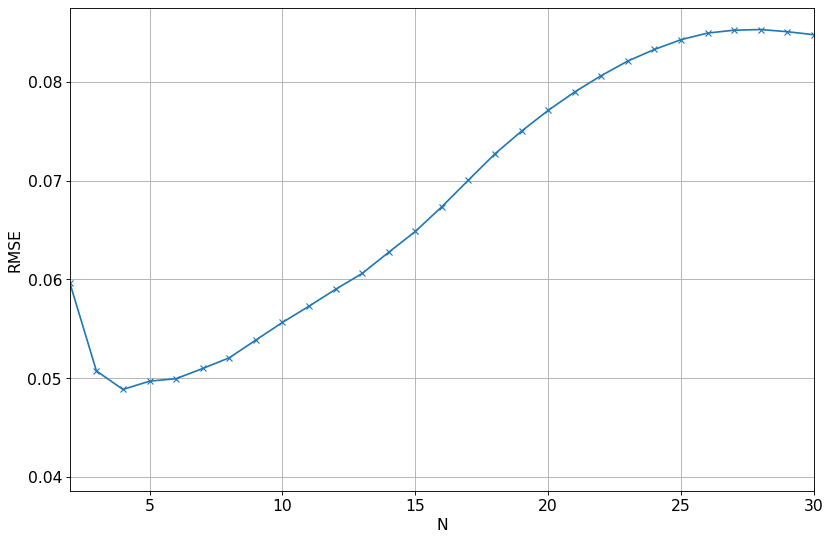

In [24]:
# Plot RMSE versus N
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), RMSE, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('RMSE')
plt.xlim([2, 30])

Lowest RMSE is achieved with N=1, followed by N=5

Text(0, 0.5, 'R2')

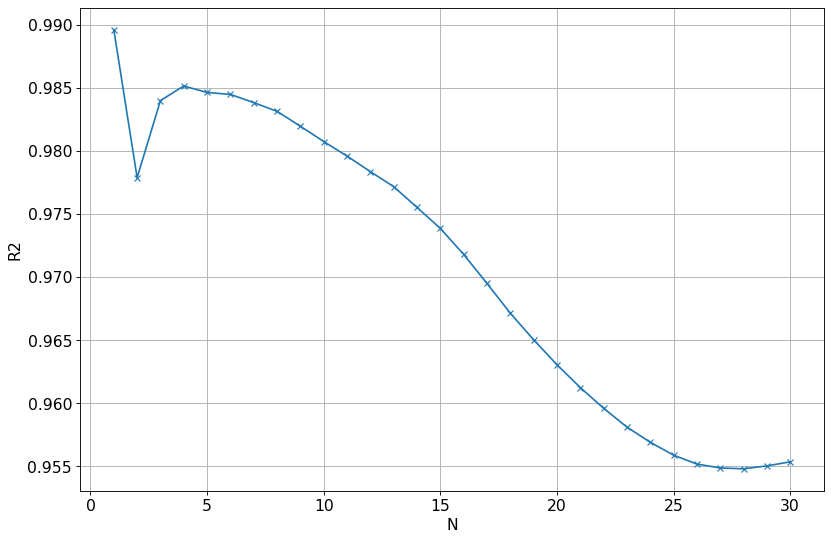

In [25]:
# Plot R2 versus N. Note for R2 larger better. 
matplotlib.rcParams.update({'font.size': 14})
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), R2, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('R2')

Text(0, 0.5, 'MAPE')

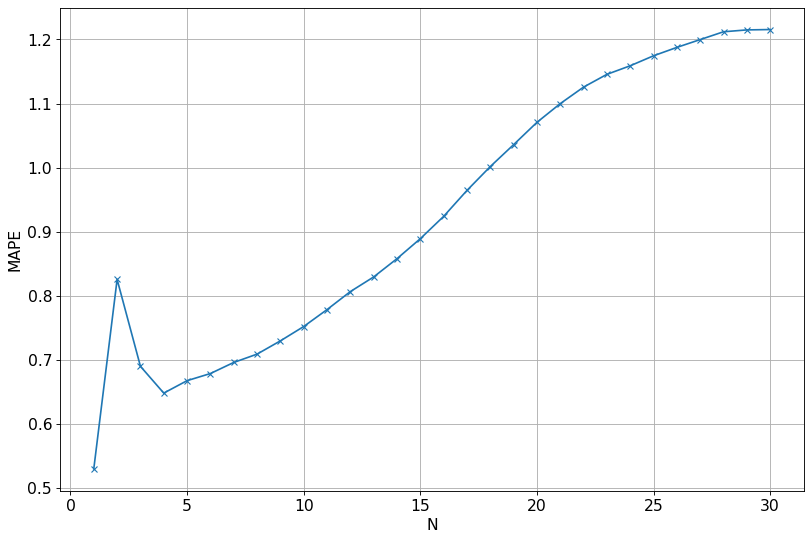

In [26]:
# Plot MAPE versus N. Note for MAPE smaller better. 
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1, Nmax+1), mape, 'x-')
plt.grid()
plt.xlabel('N')
plt.ylabel('MAPE')

In [27]:
# Set optimum N
N_opt = 4

# Plot predictions for a specific day. For checking

In [28]:
#тут есть проблемы

In [29]:
day = pd.Timestamp(date(2017, 10, 31))
day

Timestamp('2017-10-31 00:00:00')

ValueError: x and y must have same first dimension, but have shapes (6,) and (0,)

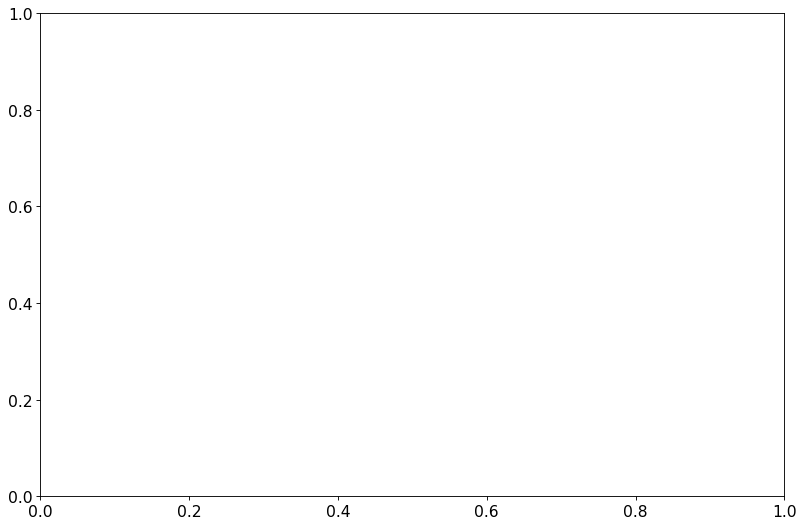

In [30]:
# Specify the day you are interested in
day = pd.Timestamp(date(2017, 10, 31))

# Specify the maximum N you want to plot (If Nmax2 is too large it gets very cluttered) 
Nmax2 = 5

df_temp = cv[cv['date'] <= day]
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(range(1,Nmax2+2), df_temp[-Nmax2-1:]['adj_close'], 'bx-')
plt.plot(Nmax2+1, df_temp[-1:]['adj_close'], 'ys-')
legend_list = ['adj_close', 'actual_value']

# Plot the linear regression lines and the predictions
color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
marker_list = ['x', 'x', 'x', 'x', 'x', 'x', 'x']
regr = LinearRegression(fit_intercept=True) # Create linear regression object
for N in range(5, Nmax2+1):
    # Plot the linear regression lines
    X_train = np.array(range(len(df_temp['adj_close'][-N-1:-1]))) # e.g. [0 1 2 3 4]
    y_train = np.array(df_temp['adj_close'][-N-1:-1]) # e.g. [2944 3088 3226 3335 3436]
    X_train = X_train.reshape(-1, 1)     
    y_train = y_train.reshape(-1, 1)
    regr.fit(X_train, y_train)            # Train the model
    y_est = regr.predict(X_train)         # Get linear regression line
    plt.plot(range(Nmax2+1-N,Nmax2+2), 
             np.concatenate((y_est, np.array(df_temp['est_N'+str(N)][-1:]).reshape(-1,1))),
             color=color_list[N%len(color_list)], 
             marker=marker_list[N%len(marker_list)])
    legend_list.append('est_N'+str(N)+'_lr')
    
    # Plot the predictions
    plt.plot(Nmax2+1, 
             df_temp['est_N'+str(N)][-1:], 
             color=color_list[N%len(color_list)], 
             marker='o')
    legend_list.append('est_N'+str(N))
    

plt.grid()
plt.xlabel('timestep')
plt.ylabel('USD')
plt.legend(legend_list, bbox_to_anchor=(1.05, 1))
matplotlib.rcParams.update({'font.size': fontsize})

# Plot predictions on dev set

Text(0, 0.5, 'Руб.')

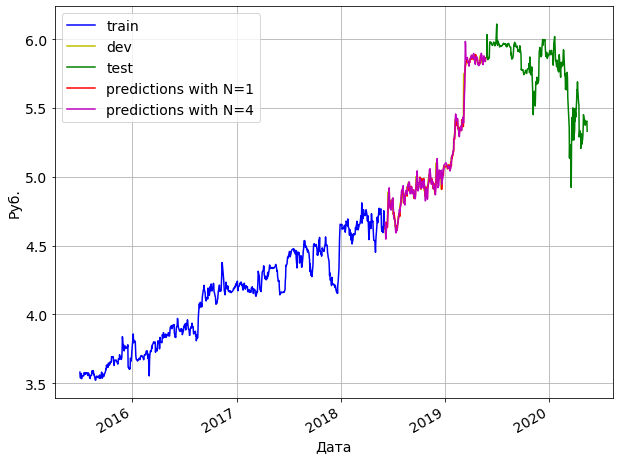

In [31]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='r-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='m-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=4'])
ax.set_xlabel("Дата")
ax.set_ylabel("Руб.")

Text(0.5, 1.0, 'Zoom in to dev set')

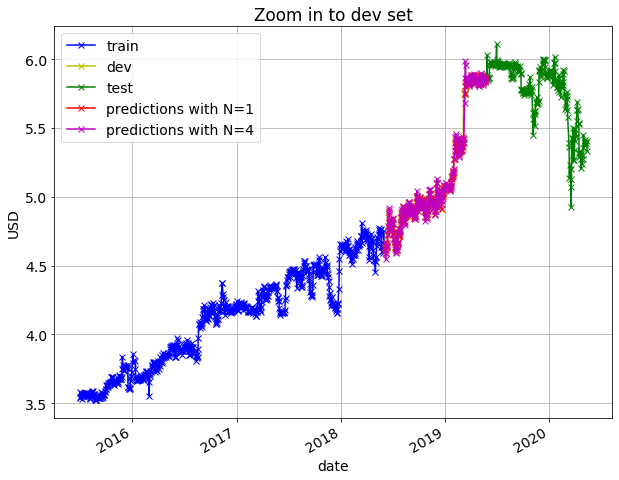

In [32]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N1', style='rx-', grid=True, ax=ax)
ax = cv.plot(x='date', y='est_N5', style='mx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N=1', 'predictions with N=4'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
#ax.set_xlim([date(2017, 11, 1), date(2017, 12, 30)])
#ax.set_ylim([127, 137])
ax.set_title('Zoom in to dev set')

# Final model

In [33]:
est_list = get_preds_lin_reg(df, 'adj_close', N_opt, 0, num_train+num_cv)
test.loc[:, 'est' + '_N' + str(N_opt)] = est_list
print("RMSE = %0.3f" % math.sqrt(mean_squared_error(est_list, test['adj_close'])))
print("R2 = %0.3f" % r2_score(test['adj_close'], est_list))
print("MAPE = %0.3f%%" % get_mape(test['adj_close'], est_list))
test.head()

RMSE = 0.079
R2 = 0.878
MAPE = 0.929%


,high,low,open,close,volume,adj_close,date,month,est_N4
Date,,,,,,,,,
2019-05-24,5.977,5.942,5.968,5.974,4047364.0,5.864000,2019-05-24,5,5.847804
2019-05-27,5.994,5.970,5.976,5.976,3770000.0,5.865963,2019-05-27,5,5.857620
2019-05-28,6.145,5.967,5.986,6.145,5831800.0,6.031851,2019-05-28,5,5.867435
2019-05-29,6.099,5.964,6.090,5.995,10606900.0,5.884613,2019-05-29,5,6.046084
2019-05-30,6.016,5.980,6.016,5.980,8087333.0,5.869890,2019-05-30,5,5.968539


Text(0, 0.5, 'USD')

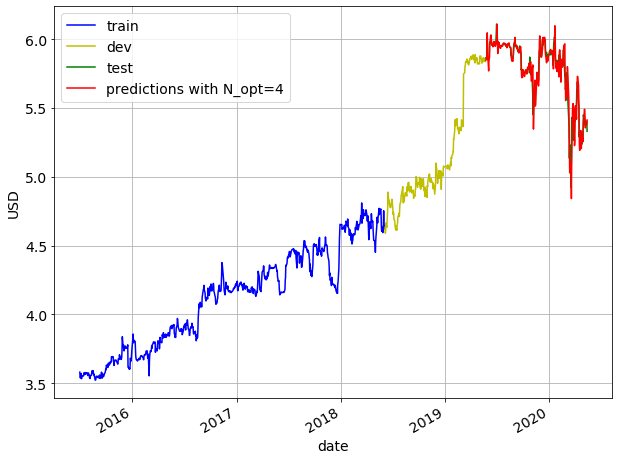

In [34]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='b-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='g-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N4', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=4'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

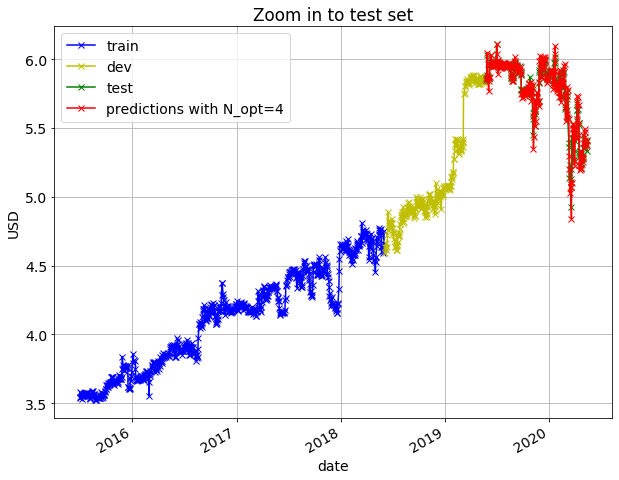

In [35]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x='date', y='adj_close', style='bx-', grid=True)
ax = cv.plot(x='date', y='adj_close', style='yx-', grid=True, ax=ax)
ax = test.plot(x='date', y='adj_close', style='gx-', grid=True, ax=ax)
ax = test.plot(x='date', y='est_N4', style='rx-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions with N_opt=4'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
#ax.set_xlim([date(2018, 6, 1), date(2018, 7, 31)])
#ax.set_ylim([135, 150])
ax.set_title('Zoom in to test set')

Text(0, 0.5, 'USD')

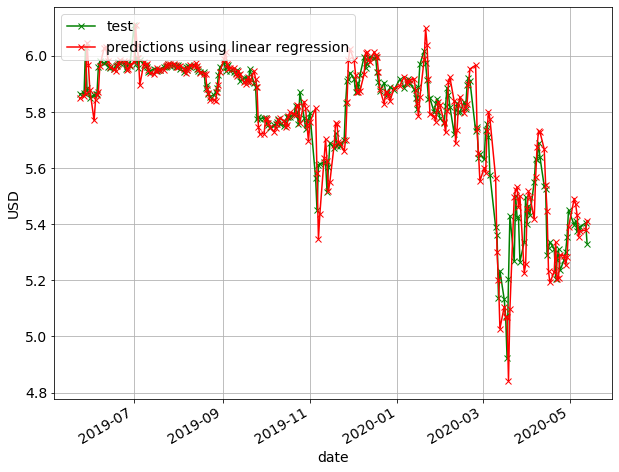

In [36]:
# Plot adjusted close over time, only for test set
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='adj_close', style='gx-', grid=True)
ax = test.plot(x='date', y='est_N4', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using linear regression'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
#ax.set_xlim([date(2018, 4, 23), date(2018, 11, 23)])
#ax.set_ylim([130, 155])

In [37]:
# Save as csv
test_lin_reg = test
#test_lin_reg.to_csv("test_lin_reg.csv")

# Findings
* On the dev set, the lowest RMSE is 1.2 which is achieved using N=1, ie. using value on day t-1 to predict value on day t
* On the dev set, the next lowest RMSE is 1.36 which is achieved using N=5, ie. using values from days t-5 to t-1 to predict value on day t
* We will use N_opt=5 in this work since our aim here is to use linear regression
* On the test set, the RMSE is 1.42 and MAPE is 0.707% using N_opt=5

In [38]:
pnl_data = test_lin_reg

In [39]:
pnl_data

,high,low,open,close,volume,adj_close,date,month,est_N4
Date,,,,,,,,,
2019-05-24,5.977,5.942,5.968,5.974,4047364.0,5.864000,2019-05-24,5,5.847804
2019-05-27,5.994,5.970,5.976,5.976,3770000.0,5.865963,2019-05-27,5,5.857620
2019-05-28,6.145,5.967,5.986,6.145,5831800.0,6.031851,2019-05-28,5,5.867435
2019-05-29,6.099,5.964,6.090,5.995,10606900.0,5.884613,2019-05-29,5,6.046084
2019-05-30,6.016,5.980,6.016,5.980,8087333.0,5.869890,2019-05-30,5,5.968539
2019-05-31,6.010,5.960,6.010,5.960,5644800.0,5.850258,2019-05-31,5,5.879215
2019-06-03,5.977,5.934,5.951,5.970,4303019.0,5.860074,2019-06-03,6,5.769277
2019-06-04,6.000,5.941,5.961,5.975,5521101.0,5.864982,2019-06-04,6,5.842896
2019-06-05,5.981,5.935,5.951,5.974,4449400.0,5.864000,2019-06-05,6,5.860074


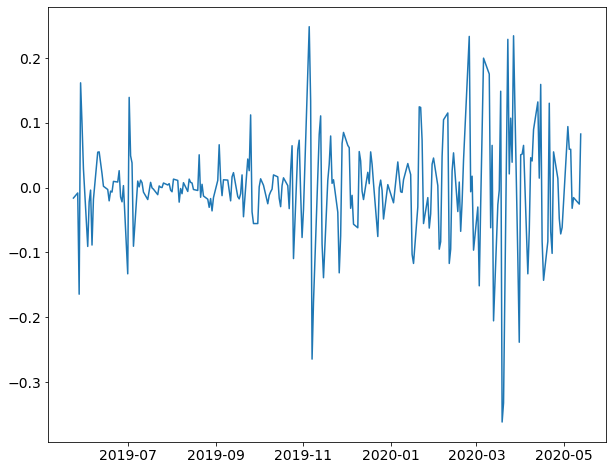

In [40]:
plt.plot(pnl_data.est_N4 - pnl_data.adj_close)

Text(0.5, 1.0, 'Сравнение ошибки модели и абсолютных значений цен акций')

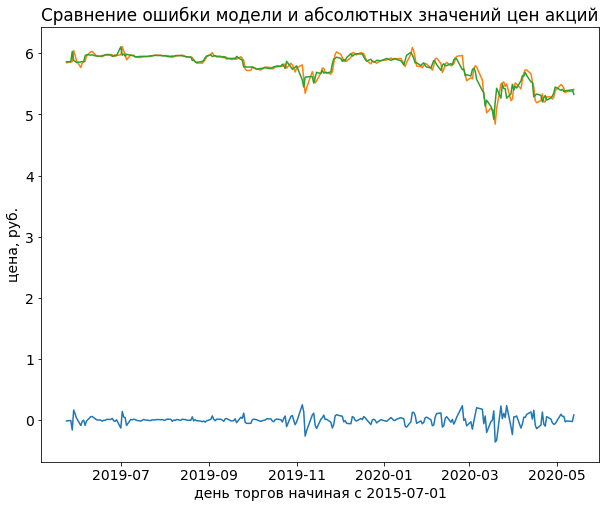

In [41]:
rcParams['figure.figsize'] = 10, 8
plt.plot(pnl_data.est_N4 - pnl_data.adj_close)
plt.plot(pnl_data.est_N4)
plt.plot(pnl_data.adj_close)
plt.xlabel("день торгов начиная с 2015-07-01")
plt.ylabel("цена, руб.")
plt.title("Сравнение ошибки модели и абсолютных значений цен акций")

In [42]:
pnl_data["position"] = ""

In [43]:
import warnings
warnings.filterwarnings("ignore")

In [44]:
for i in range(0,len(pnl_data)):
    if pnl_data.iloc[i+1,8] > pnl_data.iloc[i,8]:
        pnl_data.iloc[i,9] = 1
    else:
        pnl_data.iloc[i,9] = -1

IndexError: single positional indexer is out-of-bounds

In [48]:
pnl_data["expected difference in prices"] = pnl_data.shift(-1, axis = 0)["est_N4"] - pnl_data["est_N4"] 

In [49]:
pnl_data["daily_pnl"] = pnl_data["position"]*pnl_data["expected difference in prices"]

In [50]:
pnl_data['daily_pnl'] = pnl_data['daily_pnl'].fillna(0)
pnl_data['expected difference in prices'] = pnl_data['expected difference in prices'].fillna(0)

In [51]:
pnl_data['coef_for_pnl'] = pnl_data['daily_pnl'] + 1

In [52]:
pnl_data["cumulative_pnl"] = pnl_data.daily_pnl.cumsum()
pnl_data["cumulative_pnl_prod"] = pnl_data.coef_for_pnl.cumprod()

Text(0.5, 1.0, 'накопленная доходность')

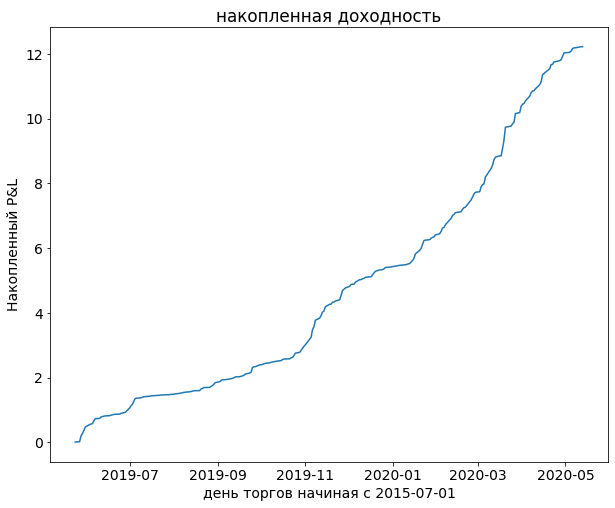

In [53]:
plt.plot(pnl_data.cumulative_pnl)
plt.xlabel("день торгов начиная с 2015-07-01")
plt.ylabel("Накопленный P&L")
plt.title("накопленная доходность")

In [54]:
results_linear_regression = pnl_data.describe()

In [55]:
pnl_data

,high,low,open,close,volume,adj_close,date,month,est_N4,position,expected difference in prices,daily_pnl,coef_for_pnl,cumulative_pnl,cumulative_pnl_prod
Date,,,,,,,,,,,,,,,
2019-05-24,5.977,5.942,5.968,5.974,4047364.0,5.864000,2019-05-24,5,5.847804,1,0.009815,0.009815,1.009815,0.009815,1.009815
2019-05-27,5.994,5.970,5.976,5.976,3770000.0,5.865963,2019-05-27,5,5.857620,1,0.009816,0.009816,1.009816,0.019631,1.019727
2019-05-28,6.145,5.967,5.986,6.145,5831800.0,6.031851,2019-05-28,5,5.867435,1,0.178649,0.178649,1.178649,0.198280,1.201901
2019-05-29,6.099,5.964,6.090,5.995,10606900.0,5.884613,2019-05-29,5,6.046084,-1,-0.077545,0.077545,1.077545,0.275826,1.295103
2019-05-30,6.016,5.980,6.016,5.980,8087333.0,5.869890,2019-05-30,5,5.968539,-1,-0.089324,0.089324,1.089324,0.365149,1.410786
2019-05-31,6.010,5.960,6.010,5.960,5644800.0,5.850258,2019-05-31,5,5.879215,-1,-0.109938,0.109938,1.109938,0.475087,1.565885
2019-06-03,5.977,5.934,5.951,5.970,4303019.0,5.860074,2019-06-03,6,5.769277,1,0.073619,0.073619,1.073619,0.548706,1.681164
2019-06-04,6.000,5.941,5.961,5.975,5521101.0,5.864982,2019-06-04,6,5.842896,1,0.017178,0.017178,1.017178,0.565884,1.710042
2019-06-05,5.981,5.935,5.951,5.974,4449400.0,5.864000,2019-06-05,6,5.860074,1,0.011288,0.011288,1.011288,0.577172,1.729345
